# **Имеем следующее задание:**

1. Используя предложенный [датасет](https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv) японских машин, обучим модель предсказывать цены на японские автомобили.
2. Создадим обучающую, тестовую и проверочную выборки.
3. Оценим качество работы созданной сети, определите средний процент ошибки на проверочной выборке.
4. В качестве ошибки будем использовать среднеквадратическую ошибку (mse).
5. Добъемся ошибки менее 5% как на тренировочной так и на тестовой выборке.


#### Загрузка необходимых библиотек и датасета

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2024-06-05 14:27:15--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv’

japan_cars_dataset. 100%[===================>] 133.53K   163KB/s    in 0.8s    

2024-06-05 14:27:18 (163 KB/s) - ‘japan_cars_dataset.csv’ saved [136735/136735]



#### Работа с датасетом

In [ ]:
df = pd.read_csv('japan_cars_dataset.csv')

df = df.drop(columns=['Unnamed: 0', 'hand_drive'])

scaler = MinMaxScaler()

# Нормализация столбца 'price'
df['price_normalized'] = scaler.fit_transform(df[['price']])
print(df.head())

   price      mark    model  year  mileage  engine_capacity transmission  \
0     80    nissan    march  2003    80000             1240           at   
1    110    nissan    march  2010    53000             1200           at   
2    165    nissan  lafesta  2005    47690             2000           at   
3    190    toyota  avensis  2008   130661             1990           at   
4    190  daihatsu     mira  2006    66300              660           at   

  drive      fuel  price_normalized  
0   2wd  gasoline          0.000000  
1   2wd  gasoline          0.022727  
2   2wd  gasoline          0.064394  
3   2wd  gasoline          0.083333  
4   2wd  gasoline          0.083333  


In [ ]:
le = LabelEncoder()
for column in ['mark', 'model', 'transmission', 'drive', 'fuel']:
    df[column] = le.fit_transform(df[column])


#### Разделение данных на выборки и масштабирование

In [ ]:
# 3. Разделение данных на обучающую, тестовую и проверочную выборки
X = df.drop(columns=['price_normalized'])
y = df['price_normalized']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Масштабирование целевой переменной
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

#### Подготовка модели

In [ ]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse', metrics=[MeanSquaredError()])

In [ ]:
checkpoint_path = "best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mean_squared_error', save_best_only=True, mode='min')

#### Обучение модели

In [ ]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])


Epoch 1/100
47/47 [==============================] - 7s 18ms/step - loss: 2.1026 - mean_squared_error: 2.1026 - val_loss: 0.1059 - val_mean_squared_error: 0.1059
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 1.4869 - mean_squared_error: 1.4869 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 1.0108 - mean_squared_error: 1.0108 - val_loss: 0.0528 - val_mean_squared_error: 0.0528
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.5399 - mean_squared_error: 0.5399 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 0.3149 - mean_squared_error: 0.3149 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 7/100
47/47 [==============

#### Загрузка лучшей модели и оценка предсказаний

47/47 [==============================] - 0s 2ms/step
Средняя абсолютная ошибка на обучающей выборке: 20.88
Средняя абсолютная процентная ошибка на обучающей выборке: 2.26%

15/15 [==============================] - 0s 2ms/step
Средняя абсолютная ошибка на проверочной выборке: 30.18
Средняя абсолютная процентная ошибка на проверочной выборке: 4.01%

Реальные и предсказанные значения для случайных выборок из проверочной выборки:
Реальное значение: 1166.00, Предсказанное: 1175.87, Разница: 9.87
Реальное значение: 550.00, Предсказанное: 581.61, Разница: 31.61
Реальное значение: 1060.00, Предсказанное: 1073.19, Разница: 13.19
Реальное значение: 600.00, Предсказанное: 655.80, Разница: 55.80
Реальное значение: 600.00, Предсказанное: 619.52, Разница: 19.52
Реальное значение: 1320.00, Предсказанное: 1291.93, Разница: 28.07
Реальное значение: 1220.00, Предсказанное: 1193.06, Разница: 26.94
Реальное значение: 1306.00, Предсказанное: 1254.57, Разница: 51.43
Реальное значение: 1306.00, Предсказанное

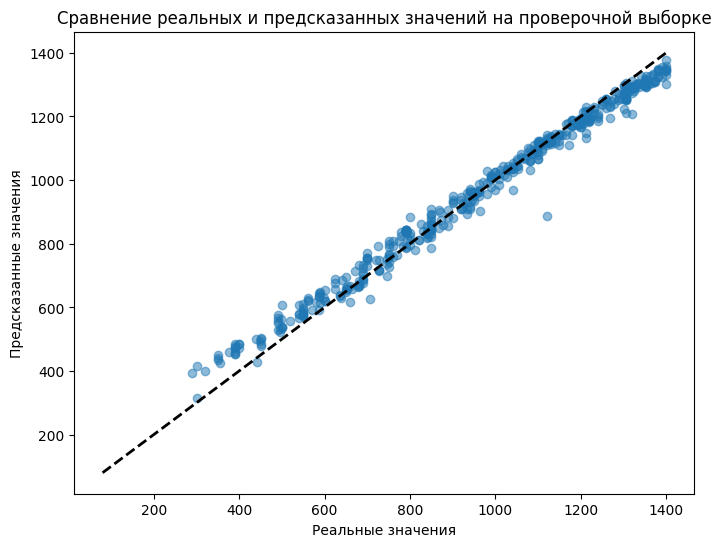

In [ ]:
best_model = load_model('best_model.keras')

# Оценка качества модели на обучающей выборке
pred_train = best_model.predict(X_train)
pred_train = scaler_y.inverse_transform(pred_train)
pred_train = pred_train * (df['price'].max() - df['price'].min()) + df['price'].min()

mae_train = mean_absolute_error(df['price'].iloc[y_train.index], pred_train)
mape_train = np.mean(np.abs((df['price'].iloc[y_train.index] - pred_train.flatten()) / df['price'].iloc[y_train.index])) * 100

print('Средняя абсолютная ошибка на обучающей выборке: {:.2f}'.format(mae_train))
print('Средняя абсолютная процентная ошибка на обучающей выборке: {:.2f}%\n'.format(mape_train))

# Оценка качества модели на проверочной выборке
pred_test = model.predict(X_test)
pred_test = scaler_y.inverse_transform(pred_test)
pred_test = pred_test * (df['price'].max() - df['price'].min()) + df['price'].min()

mae_test = mean_absolute_error(df['price'].iloc[y_test.index], pred_test)
mape_test = np.mean(np.abs((df['price'].iloc[y_test.index] - pred_test.flatten()) / df['price'].iloc[y_test.index])) * 100

print('Средняя абсолютная ошибка на проверочной выборке: {:.2f}'.format(mae_test))
print('Средняя абсолютная процентная ошибка на проверочной выборке: {:.2f}%\n'.format(mape_test))


random_indices = np.random.choice(len(y_test), 15, replace=False)

print('Реальные и предсказанные значения для случайных выборок из проверочной выборки:')
for i in random_indices:
    print('Реальное значение: {:.2f}, Предсказанное: {:.2f}, Разница: {:.2f}'.format(
        df['price'].iloc[y_test.index[i]], pred_test[i][0], abs(df['price'].iloc[y_test.index[i]] - pred_test[i][0])))


fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df['price'].iloc[y_test.index], pred_test, alpha=0.5)
ax.plot([df['price'].min(), df['price'].max()], [df['price'].min(), df['price'].max()], 'k--', lw=2)
ax.set_xlabel('Реальные значения')
ax.set_ylabel('Предсказанные значения')
ax.set_title('Сравнение реальных и предсказанных значений на проверочной выборке')
plt.show()